In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm


In [47]:

# 1. Data Cleaning

# Load data
df = pd.read_csv('/Users/sruthi/Documents/Predictive Analytics/Week 2/adjusted_car_sales_data.csv')

In [48]:
# Initial data exploration
print(df.shape)
print(df.info())
print(df.describe())

(15000, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   PricePaid          15000 non-null  float64
 1   Age                13200 non-null  float64
 2   Income             11700 non-null  float64
 3   CreditScore        13800 non-null  float64
 4   PreviousCarOwned   15000 non-null  int64  
 5   VehicleType        15000 non-null  object 
 6   Brand              15000 non-null  object 
 7   Gender             15000 non-null  object 
 8   MaritalStatus      11850 non-null  object 
 9   Region             15000 non-null  object 
 10  PrevCarDoors       15000 non-null  int64  
 11  NumKids            15000 non-null  int64  
 12  YearsOwnedPrevCar  15000 non-null  int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 1.5+ MB
None
          PricePaid           Age         Income   CreditScore  \
count  15000.000000  13200

In [49]:
# Handling outliers
df = df[df['Age'] >= 18]


In [50]:
# Handling missing data
# Age, Income, CreditScore imputation using KNN
knn_imputer = KNNImputer(n_neighbors=5)
df[['Age', 'Income', 'CreditScore']] = knn_imputer.fit_transform(df[['Age', 'Income', 'CreditScore']])


In [51]:
# Marital Status imputation using mode
df['MaritalStatus'] = df.groupby('YearsOwnedPrevCar')['MaritalStatus'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

In [52]:
# Verify missing values
print(df.isnull().sum())

PricePaid            0
Age                  0
Income               0
CreditScore          0
PreviousCarOwned     0
VehicleType          0
Brand                0
Gender               0
MaritalStatus        0
Region               0
PrevCarDoors         0
NumKids              0
YearsOwnedPrevCar    0
dtype: int64


In [53]:
# Apply Ordinal Encoding to VehicleType and Brand
ordinal_encoder = OrdinalEncoder(categories=[['Sedan', 'SUV'], ['Ford', 'Chevy', 'Dodge']])
df[['VehicleType', 'Brand']] = ordinal_encoder.fit_transform(df[['VehicleType', 'Brand']])


In [54]:
# One-Hot Encoding for other categorical variables
categorical_columns = ['Gender', 'MaritalStatus', 'Region']
ohe_encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_data = ohe_encoder.fit_transform(df[categorical_columns])
encoded_df = pd.DataFrame(encoded_data, columns=ohe_encoder.get_feature_names_out(categorical_columns))


In [55]:
# Merge encoded data with the original dataframe
df = pd.concat([df.drop(columns=categorical_columns), encoded_df], axis=1)


In [56]:
# Verify data after encoding
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 14734 entries, 0 to 13014
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   PricePaid             13021 non-null  float64
 1   Age                   13021 non-null  float64
 2   Income                13021 non-null  float64
 3   CreditScore           13021 non-null  float64
 4   PreviousCarOwned      13021 non-null  float64
 5   VehicleType           13021 non-null  float64
 6   Brand                 13021 non-null  float64
 7   PrevCarDoors          13021 non-null  float64
 8   NumKids               13021 non-null  float64
 9   YearsOwnedPrevCar     13021 non-null  float64
 10  Gender_Male           13021 non-null  float64
 11  MaritalStatus_Single  13021 non-null  float64
 12  Region_North          13021 non-null  float64
 13  Region_South          13021 non-null  float64
 14  Region_West           13021 non-null  float64
dtypes: float64(15)
memory us

In [57]:
# Ensure all data is numeric
df = df.apply(pd.to_numeric, errors='coerce')


In [58]:
# Handle missing values by filling with the mean or any appropriate method
df = df.fillna(df.mean())


In [59]:
# Check for any infinite values and replace them with NaN, then fill them with the mean
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.fillna(df.mean())


In [60]:
# Verify no more NaN values
print(df.isnull().sum())


PricePaid               0
Age                     0
Income                  0
CreditScore             0
PreviousCarOwned        0
VehicleType             0
Brand                   0
PrevCarDoors            0
NumKids                 0
YearsOwnedPrevCar       0
Gender_Male             0
MaritalStatus_Single    0
Region_North            0
Region_South            0
Region_West             0
dtype: int64


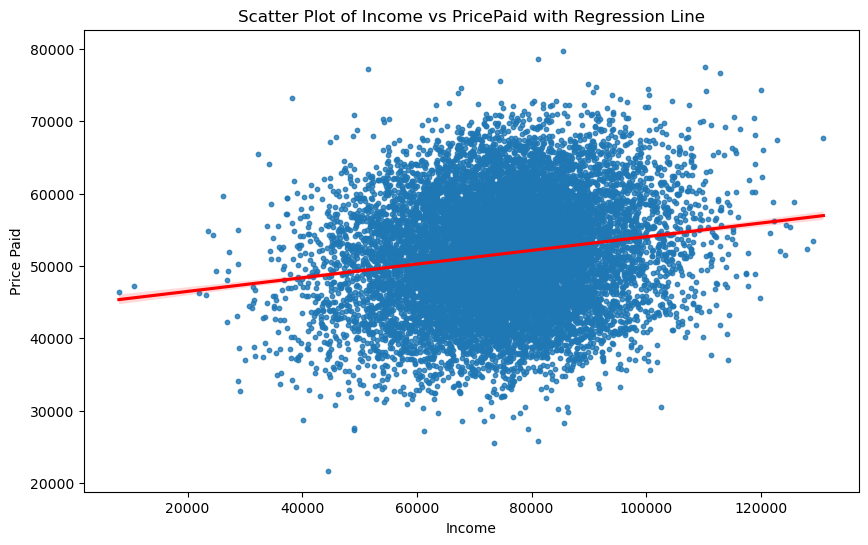

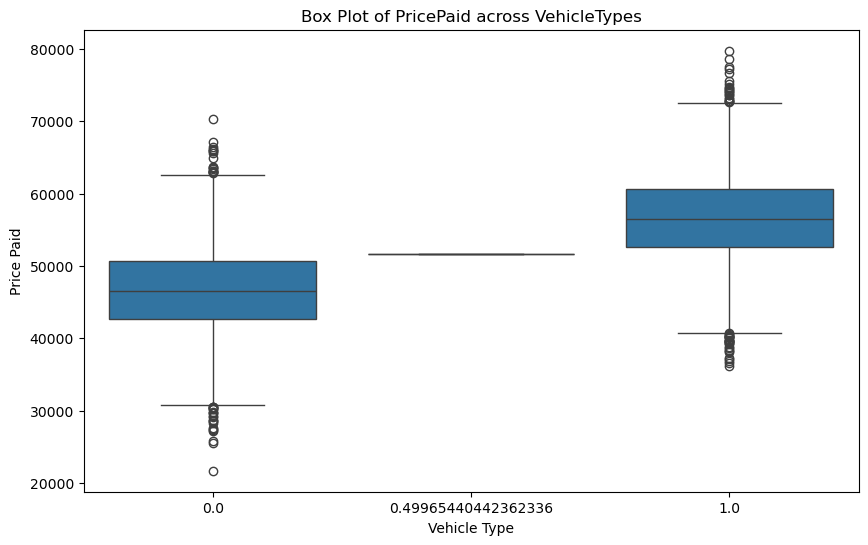

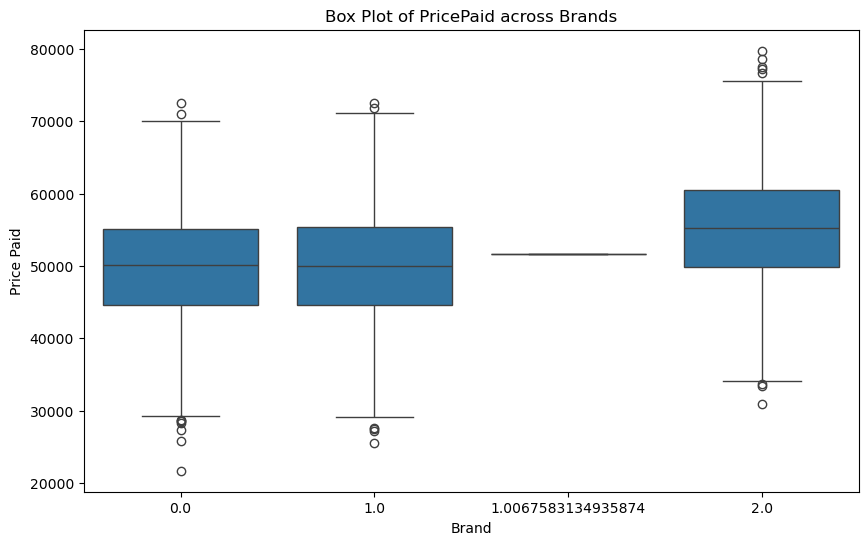

In [61]:
# 2. EDA
# Scatter Plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(x='Income', y='PricePaid', data=df, scatter_kws={'s':10}, line_kws={'color':'red'})
plt.title('Scatter Plot of Income vs PricePaid with Regression Line')
plt.xlabel('Income')
plt.ylabel('Price Paid')
plt.show()

# Box Plot for PricePaid across different VehicleTypes
plt.figure(figsize=(10, 6))
sns.boxplot(x='VehicleType', y='PricePaid', data=df)
plt.title('Box Plot of PricePaid across VehicleTypes')
plt.xlabel('Vehicle Type')
plt.ylabel('Price Paid')
plt.show()

# Box Plot for PricePaid across different Brands
plt.figure(figsize=(10, 6))
sns.boxplot(x='Brand', y='PricePaid', data=df)
plt.title('Box Plot of PricePaid across Brands')
plt.xlabel('Brand')
plt.ylabel('Price Paid')
plt.show()

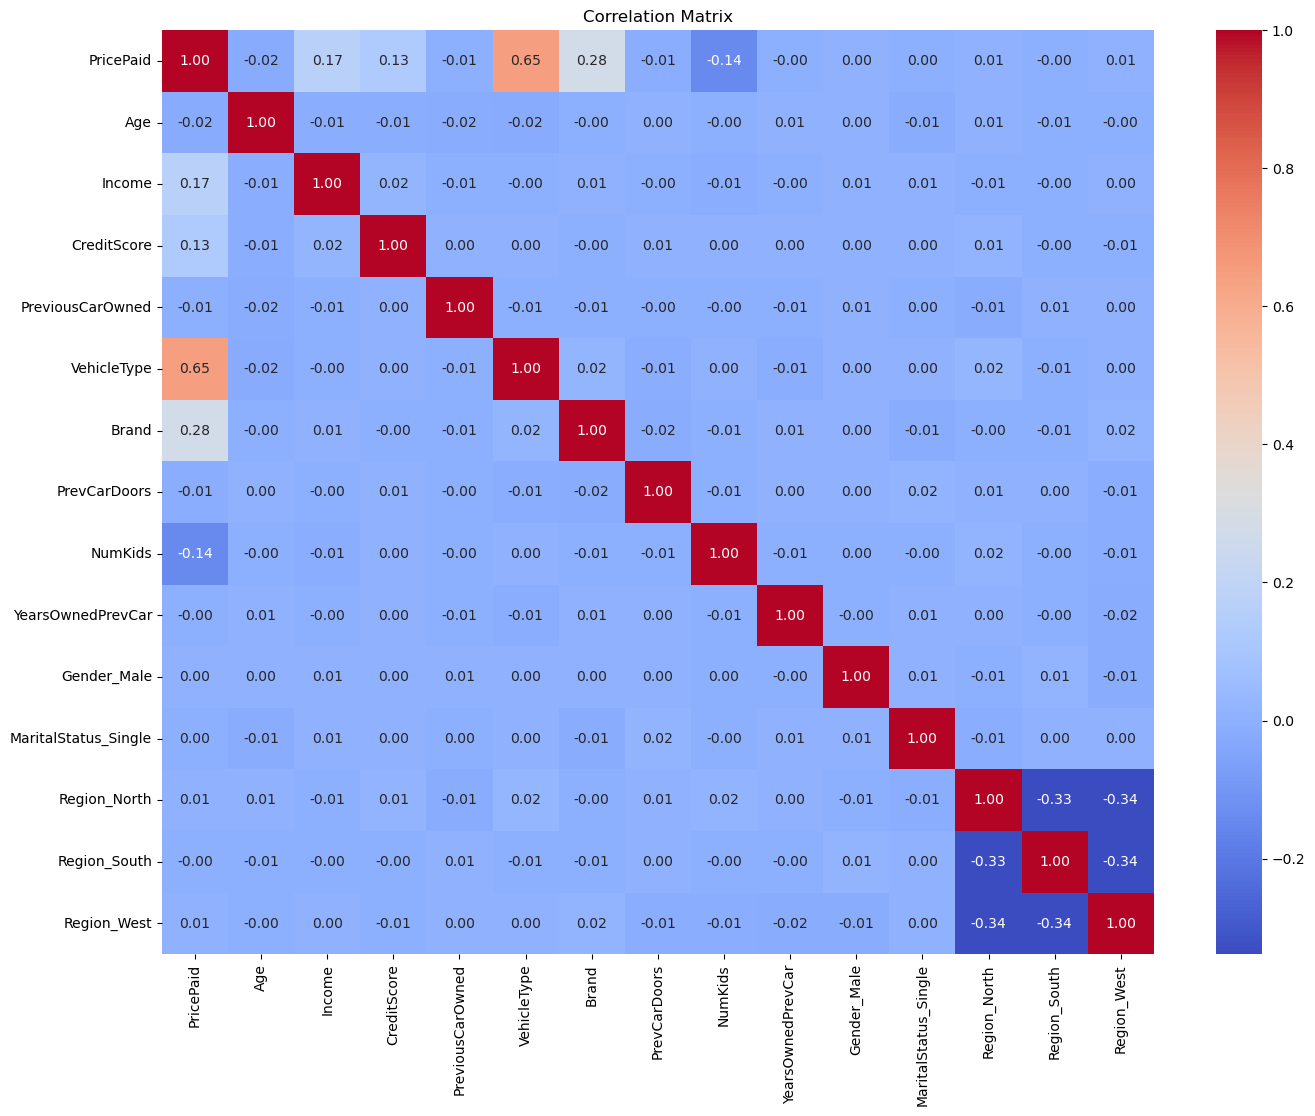

In [62]:
# Calculate and plot the correlation matrix
correlation_matrix = df.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [63]:
# Calculate VIF
X = df.drop(columns='PricePaid')
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(X.mean())
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X = X.fillna(X.mean())

def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

vif_df = calculate_vif(X)
print(vif_df)


                 Feature        VIF
0                    Age  19.724279
1                 Income  31.607203
2            CreditScore  67.758220
3       PreviousCarOwned   6.560553
4            VehicleType   2.125517
5                  Brand   2.725520
6           PrevCarDoors  15.647759
7                NumKids   3.035586
8      YearsOwnedPrevCar   5.143904
9            Gender_Male   2.088018
10  MaritalStatus_Single   2.291314
11          Region_North   2.082842
12          Region_South   2.061823
13           Region_West   2.086068


In [64]:
# Calculate p-values
X_with_const = sm.add_constant(X)
model = sm.OLS(df['PricePaid'], X_with_const).fit()
pvalues_df = pd.DataFrame({
    'Feature': X.columns,
    'P-Value': model.pvalues[1:].values
})
print(pvalues_df)

                 Feature        P-Value
0                    Age   7.400163e-01
1                 Income  2.079478e-182
2            CreditScore  2.150517e-116
3       PreviousCarOwned   9.552876e-01
4            VehicleType   0.000000e+00
5                  Brand   0.000000e+00
6           PrevCarDoors   9.197652e-01
7                NumKids  3.378544e-143
8      YearsOwnedPrevCar   8.581785e-01
9            Gender_Male   8.830183e-01
10  MaritalStatus_Single   8.820857e-01
11          Region_North   7.025611e-01
12          Region_South   2.477329e-01
13           Region_West   3.357257e-01


In [65]:
# 3. Modeling

# Splitting data into features and target variable
X = df.drop(columns='PricePaid')
y = df['PricePaid']


In [66]:
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [67]:
# Split the standardized data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [68]:
# First model: Using all variables
model_all = LinearRegression()
model_all.fit(X_train, y_train)


LinearRegression()

In [69]:
# Predict and evaluate the model
y_pred_all = model_all.predict(X_test)
r2_all = model_all.score(X_test, y_test)

In [70]:
# Use statsmodels to calculate AIC
X_train_all = sm.add_constant(X_train)
model_all_sm = sm.OLS(y_train, X_train_all).fit()
aic_all = model_all_sm.aic


In [71]:
# Display the R-squared and AIC for the model using all variables
print(f'R-squared for the model using all variables: {r2_all}')
print(f'AIC for the model using all variables: {aic_all}')

R-squared for the model using all variables: 0.5644803773725102
AIC for the model using all variables: 233753.0204267894


In [72]:
# 4. Optimization (Forward and Backward Selection)

# Stepwise selection based on p-value and AIC
def stepwise_selection(X, y, initial_list=[], threshold_in=0.05, threshold_out=0.10, verbose=True):
    included = list(initial_list)
    while True:
        changed = False
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]], index=y.index))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print(f'Add  {best_feature:30} with p-value {best_pval:.6}')
                print(f'Current included features: {included}')
                print(f'Current p-values: {model.pvalues}')
        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included], index=y.index))).fit()
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f'Drop {worst_feature:30} with p-value {worst_pval:.6}')
                print(f'Current included features: {included}')
                print(f'Current p-values: {model.pvalues}')
        if not changed:
            break
    return included

X_train_df = pd.DataFrame(X_train, columns=X.columns, index=y_train.index)
X_test_df = pd.DataFrame(X_test, columns=X.columns, index=y_test.index)

selected_features = stepwise_selection(X_train_df, y_train)

Add  VehicleType                    with p-value 0.0
Current included features: ['VehicleType']
Current p-values: const           0.000000
Region_North    0.097891
dtype: float64
Add  Brand                          with p-value 0.0
Current included features: ['VehicleType', 'Brand']
Current p-values: const           0.00000
VehicleType     0.00000
Region_North    0.72333
dtype: float64
Add  Income                         with p-value 3.56509e-146
Current included features: ['VehicleType', 'Brand', 'Income']
Current p-values: const           0.000000
VehicleType     0.000000
Brand           0.000000
Region_North    0.754848
dtype: float64
Add  NumKids                        with p-value 1.76307e-108
Current included features: ['VehicleType', 'Brand', 'Income', 'NumKids']
Current p-values: const            0.000000e+00
VehicleType      0.000000e+00
Brand            0.000000e+00
Income          3.716962e-146
Region_North     7.906941e-01
dtype: float64
Add  CreditScore                    

In [73]:
# Train the second model with selected features
X_train_selected = X_train_df[selected_features]
X_test_selected = X_test_df[selected_features]

model_selected = LinearRegression()
model_selected.fit(X_train_selected, y_train)


LinearRegression()

In [74]:
# Predict and evaluate the second model
y_pred_selected = model_selected.predict(X_test_selected)
r2_selected = model_selected.score(X_test_selected, y_test)

In [75]:
# Use statsmodels to calculate AIC for the second model
X_train_selected_sm = sm.add_constant(X_train_selected)
model_selected_sm = sm.OLS(y_train, X_train_selected_sm).fit()
aic_selected = model_selected_sm.aic

In [76]:
# Display the R-squared and AIC for the stepwise selection model
print(f'R-squared for the stepwise selection model: {r2_selected}')
print(f'AIC for the stepwise selection model: {aic_selected}')


R-squared for the stepwise selection model: 0.5650065877952921
AIC for the stepwise selection model: 233738.45699330082


In [77]:
# Summary of the final selected model using statsmodels
print(model_selected_sm.summary())

# Comparison and discussion
print("\nComparison:")
print(f"Initial Model - R-squared: {r2_all}, AIC: {aic_all}")
print(f"Stepwise Model - R-squared: {r2_selected}, AIC: {aic_selected}")


                            OLS Regression Results                            
Dep. Variable:              PricePaid   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     2885.
Date:                Sun, 21 Jul 2024   Prob (F-statistic):               0.00
Time:                        15:43:19   Log-Likelihood:            -1.1686e+05
No. Observations:               11787   AIC:                         2.337e+05
Df Residuals:                   11781   BIC:                         2.338e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        5.169e+04     45.086   1146.487      